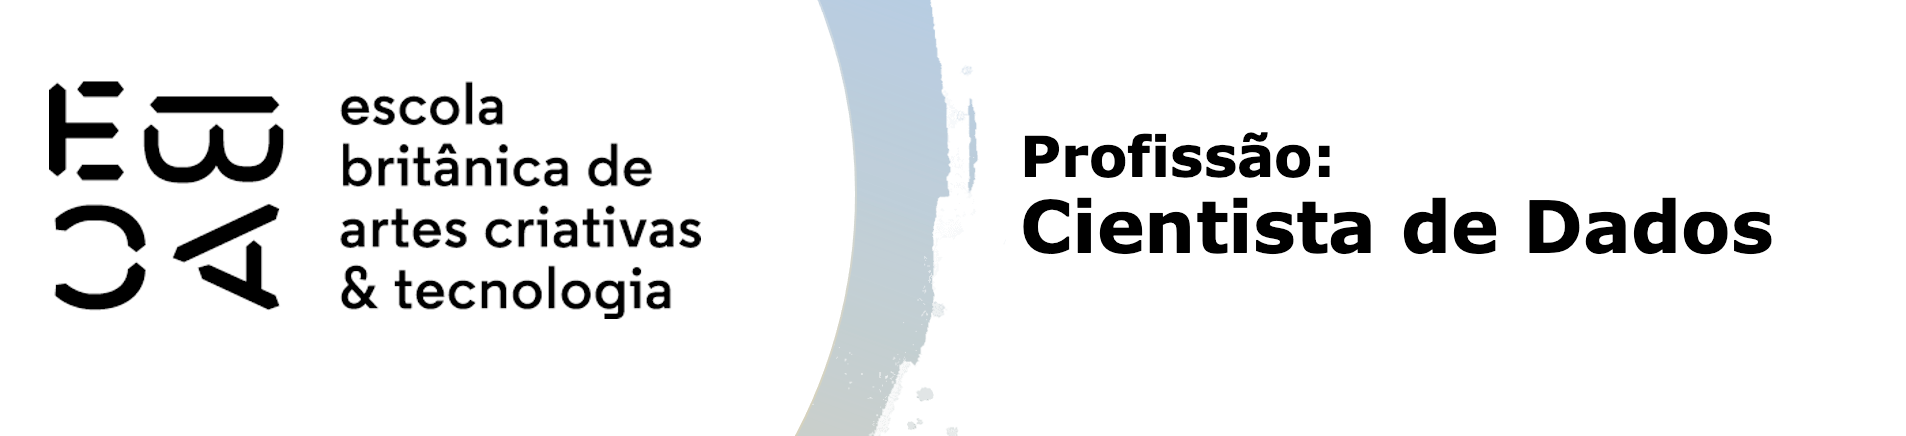

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import shapiro
import warnings

In [203]:
warnings.filterwarnings("ignore")

In [205]:
df = pd.read_csv(r'C:\Users\Joel\Downloads\Data Scientist\Mod 35/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [208]:
# Remover as colunas 'data_ref' e 'index' que não serão utilizadas no modelo
df = df.drop(columns=['data_ref', 'index'])

In [210]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

tempo_emprego    125760
dtype: int64


In [212]:
# Calcular a média da coluna 'tempo_emprego', ignorando valores ausentes
media_tempo_emprego = df['tempo_emprego'].mean()

# Substituir valores ausentes pela média calculada
df['tempo_emprego'].fillna(media_tempo_emprego, inplace=True)

In [214]:
# Verificar se ainda existem valores ausentes na coluna 'tempo_emprego'
missing_values = df['tempo_emprego'].isnull().sum()
print(f"Valores ausentes em 'tempo_emprego': {missing_values}")

Valores ausentes em 'tempo_emprego': 0


In [216]:
# Separar a variável target e aplicar a transformação logarítmica
df['log_renda'] = np.log(df['renda'])

In [218]:
# Separar em treino (70%) e teste (30%)
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [220]:
# Criar fórmula considerando todas as variáveis independentes
variaveis = list(df.drop(columns=['renda', 'log_renda']).columns)
formula = 'log_renda ~ ' + ' + '.join(variaveis)

# Ajustar o modelo na base de treino
model = smf.ols(formula=formula, data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.419e+04
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:29:40   Log-Likelihood:            -7.4519e+05
No. Observations:              525000   AIC:                         1.490e+06
Df Residuals:                  524975   BIC:                         1.491e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

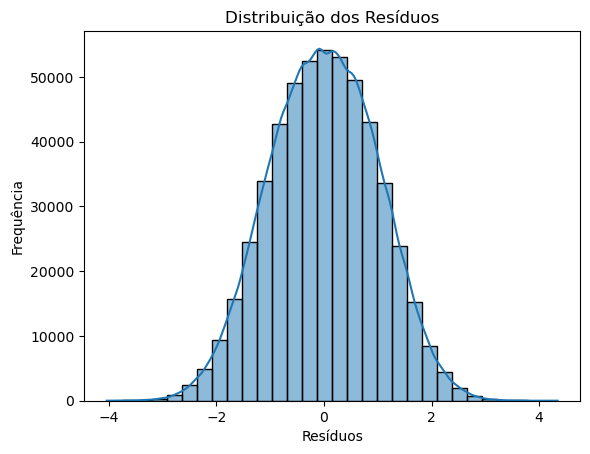

Statística: 0.9987275004386902, p-valor: 4.148894428249702e-40


In [221]:
# Calcular resíduos
train['residuos'] = model.resid

# Verificar a normalidade dos resíduos
sns.histplot(train['residuos'], kde=True, bins=30)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Teste de normalidade (Shapiro-Wilk)
from scipy.stats import shapiro
stat, p = shapiro(train['residuos'])
print(f'Statística: {stat}, p-valor: {p}')

In [222]:
# Calcular os resíduos
train['residuos'] = train['log_renda'] - model.predict(sm.add_constant(train.drop(columns=['log_renda'])))

In [223]:
# Aumentar o limite de chunksize
mpl.rcParams['agg.path.chunksize'] = 10000

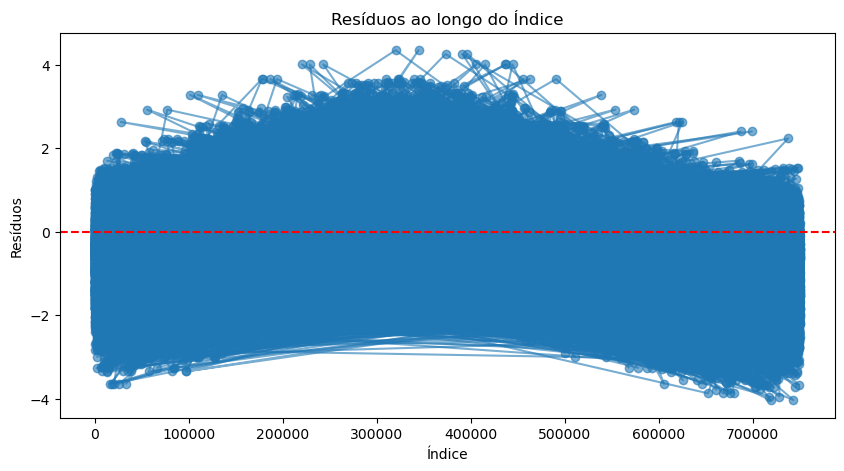

In [224]:
# Gráfico de resíduos ao longo do índice (ou variável temporal)
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['residuos'], linestyle='-', marker='o', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos ao longo do Índice')
plt.xlabel('Índice')
plt.ylabel('Resíduos')
plt.show()

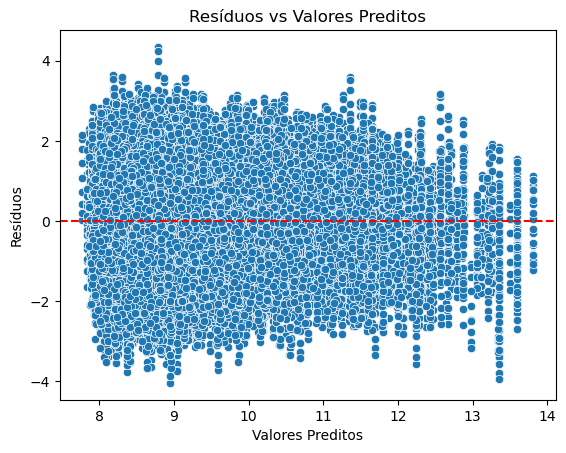

In [225]:
# Valores previstos
train['valores_preditos'] = model.fittedvalues

# Gráfico
sns.scatterplot(x=train['valores_preditos'], y=train['residuos'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()

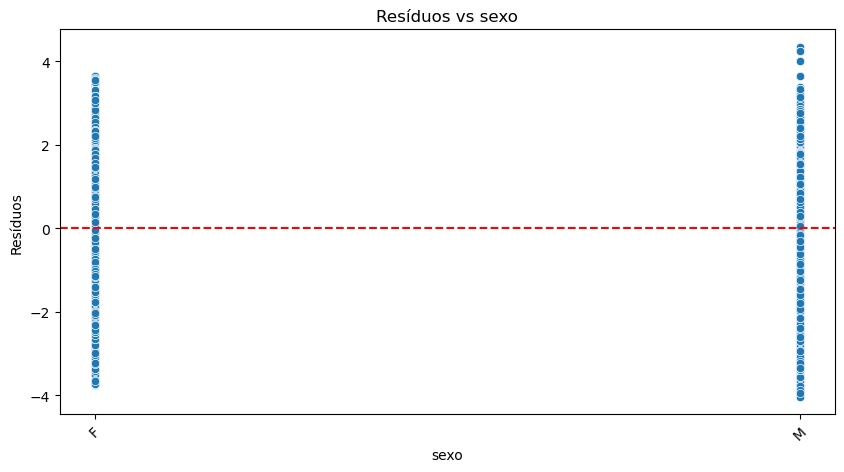

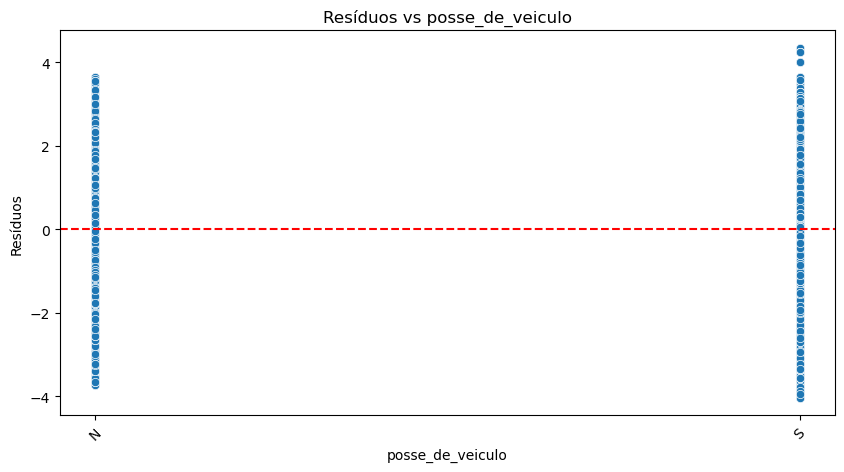

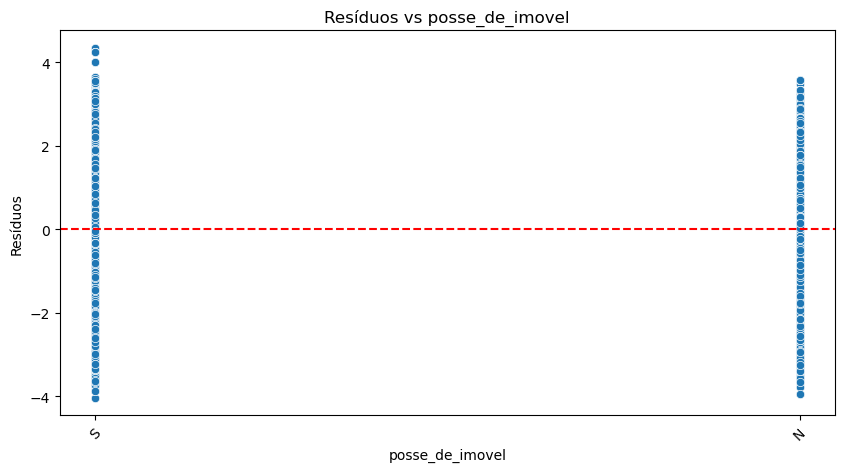

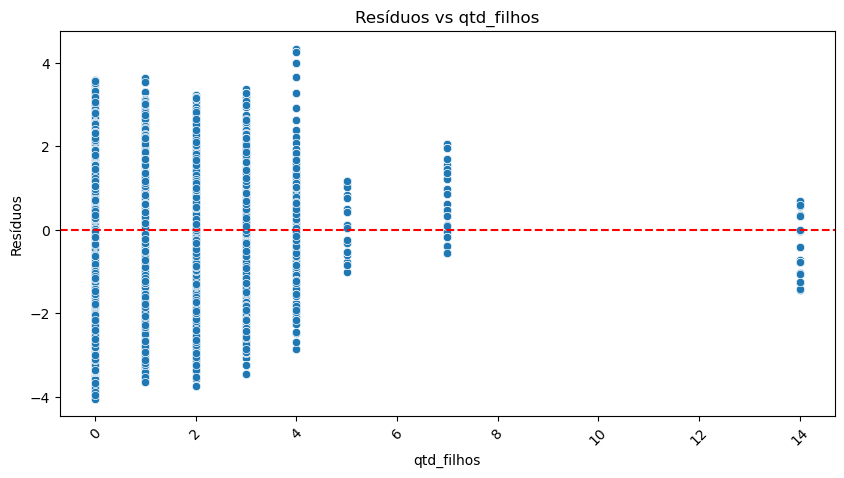

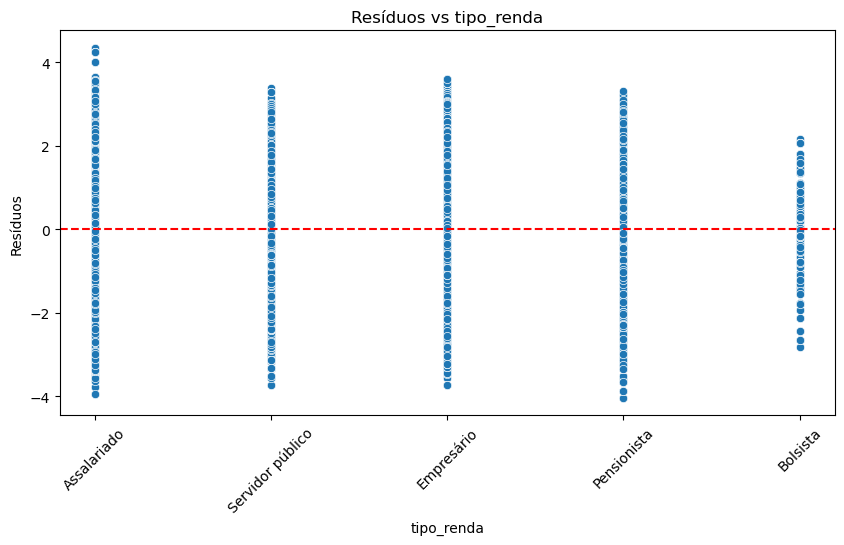

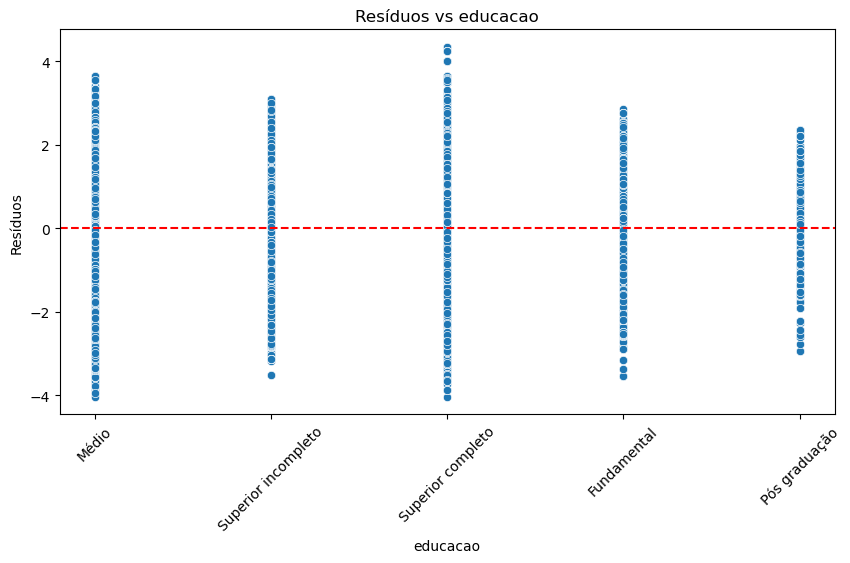

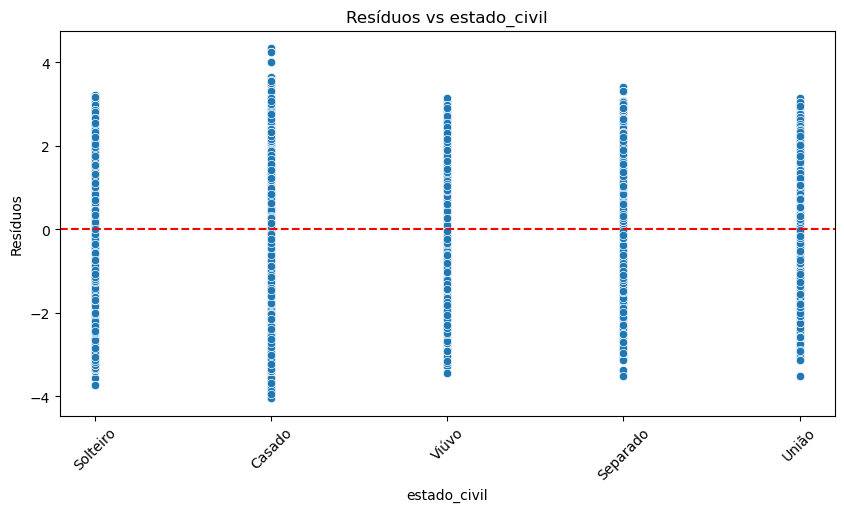

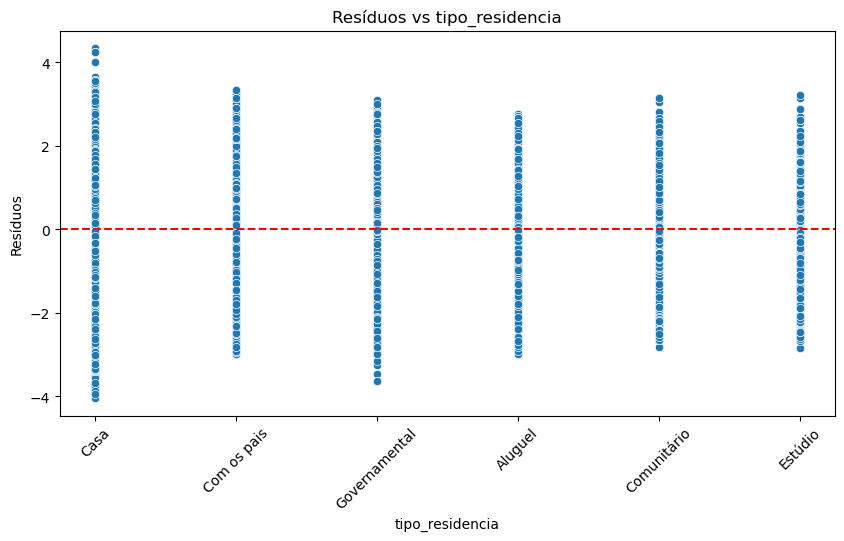

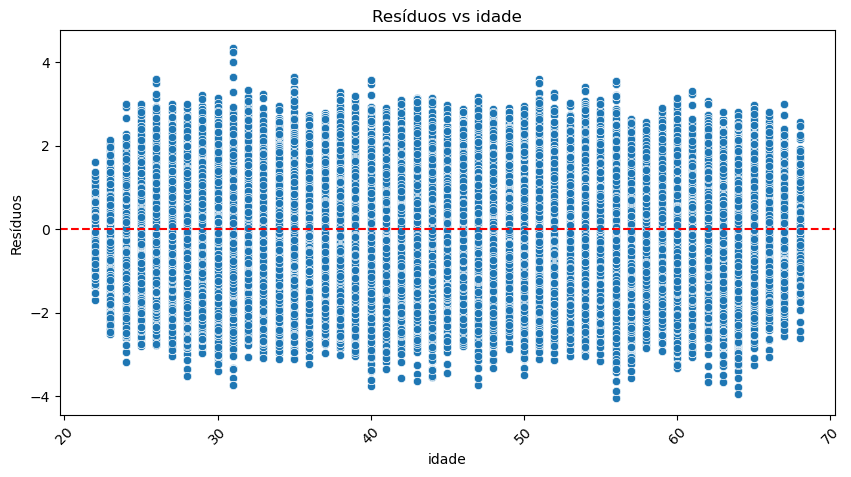

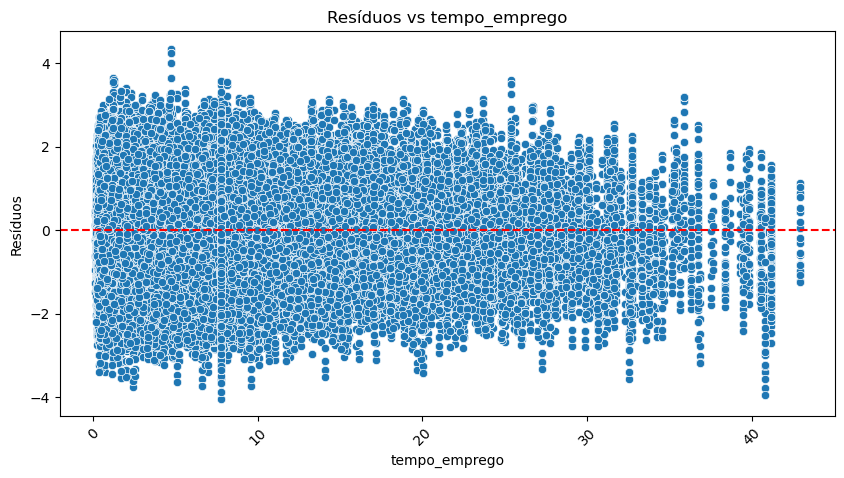

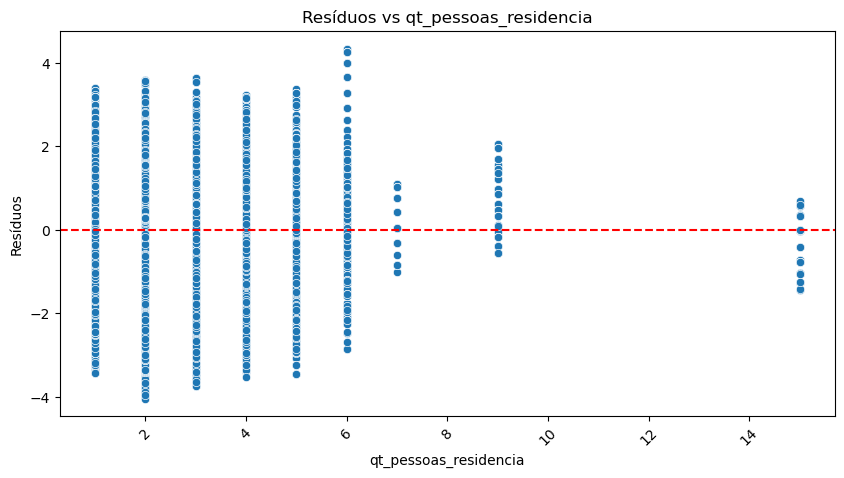

In [226]:
# Avaliar relação com cada variável independente
for var in variaveis:
    plt.figure(figsize=(10, 5))  # Tamanho da figura
    sns.scatterplot(x=train[var], y=train['residuos'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Resíduos vs {var}')
    plt.xlabel(var)
    plt.ylabel('Resíduos')
    
    # Rotacionar os rótulos do eixo x em 45 graus
    plt.xticks(rotation=45)
    
    plt.show()

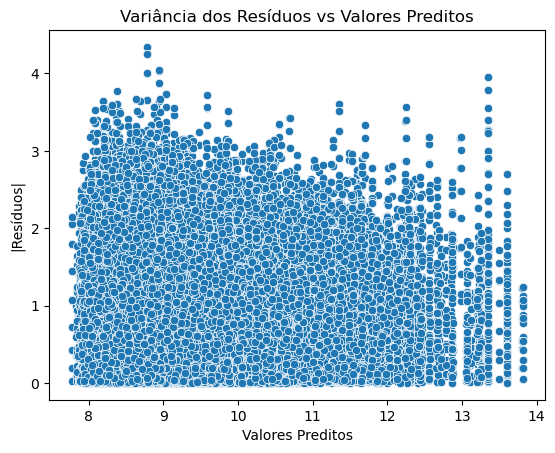

In [227]:
sns.scatterplot(x=train['valores_preditos'], y=np.abs(train['residuos']))
plt.title('Variância dos Resíduos vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('|Resíduos|')
plt.show()

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

Número de outliers identificados: 629
        studentized_residuals
587986              -3.261294
443720               3.258284
319868               3.063268
351927               3.006926
359844               3.006926
...                       ...
595376              -3.041857
623502              -3.222339
344866               3.555157
388612               3.006926
281570               3.063979

[629 rows x 1 columns]


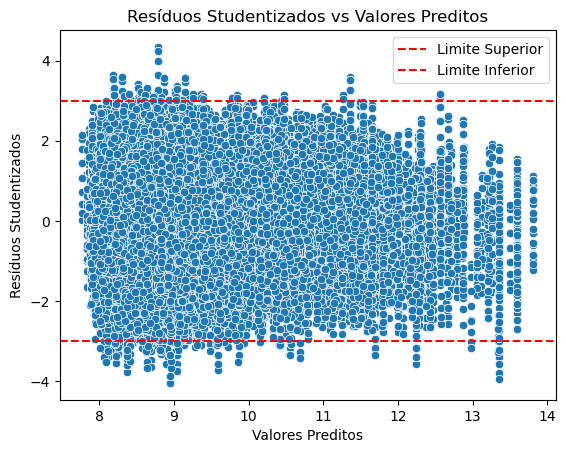

In [231]:
# Criar um objeto para calcular influências
influence = OLSInfluence(model)

# Resíduos studentizados
train['studentized_residuals'] = influence.resid_studentized_internal

# Visualizar outliers
outliers = train[np.abs(train['studentized_residuals']) > 3]
print(f"Número de outliers identificados: {len(outliers)}")
print(outliers[['studentized_residuals']])

# Plot dos resíduos studentizados
sns.scatterplot(x=train['valores_preditos'], y=train['studentized_residuals'])
plt.axhline(y=3, color='r', linestyle='--', label='Limite Superior')
plt.axhline(y=-3, color='r', linestyle='--', label='Limite Inferior')
plt.title('Resíduos Studentizados vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos Studentizados')
plt.legend()
plt.show()

Número de pontos influentes (Cook > 0.5): 0
Empty DataFrame
Columns: [cooks_distance]
Index: []


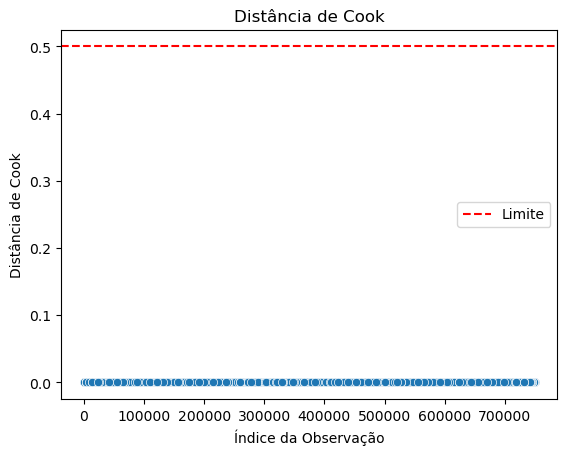

In [232]:
# Distância de Cook
train['cooks_distance'] = influence.cooks_distance[0]

# Identificar pontos influentes
influentes = train[train['cooks_distance'] > 0.5]
print(f"Número de pontos influentes (Cook > 0.5): {len(influentes)}")
print(influentes[['cooks_distance']])

# Plot da distância de Cook
sns.scatterplot(x=train.index, y=train['cooks_distance'])
plt.axhline(y=0.5, color='r', linestyle='--', label='Limite')
plt.title('Distância de Cook')
plt.xlabel('Índice da Observação')
plt.ylabel('Distância de Cook')
plt.legend()
plt.show()

Limite para leverage: 9.523809523809524e-05
Número de observações com leverage alto: 30031
        leverage
573134  0.000098
59626   0.000097
82444   0.000154
721401  0.000153
620590  0.000156
...          ...
384681  0.000103
184779  0.000172
199041  0.000182
175203  0.000284
87498   0.000103

[30031 rows x 1 columns]


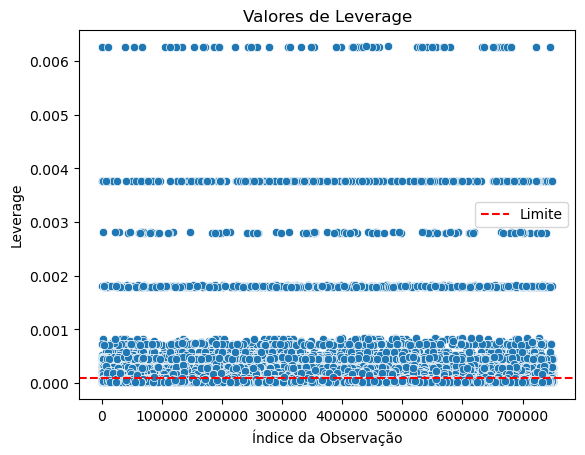

In [233]:
# Valores de leverage
train['leverage'] = influence.hat_matrix_diag

# Identificar observações com leverage alto (regra geral: leverage > 2*p/n)
n = len(train)
p = len(model.params)
leverage_threshold = 2 * p / n
print(f"Limite para leverage: {leverage_threshold}")

leverage_outliers = train[train['leverage'] > leverage_threshold]
print(f"Número de observações com leverage alto: {len(leverage_outliers)}")
print(leverage_outliers[['leverage']])

# Plot de leverage
sns.scatterplot(x=train.index, y=train['leverage'])
plt.axhline(y=leverage_threshold, color='r', linestyle='--', label='Limite')
plt.title('Valores de Leverage')
plt.xlabel('Índice da Observação')
plt.ylabel('Leverage')
plt.legend()
plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

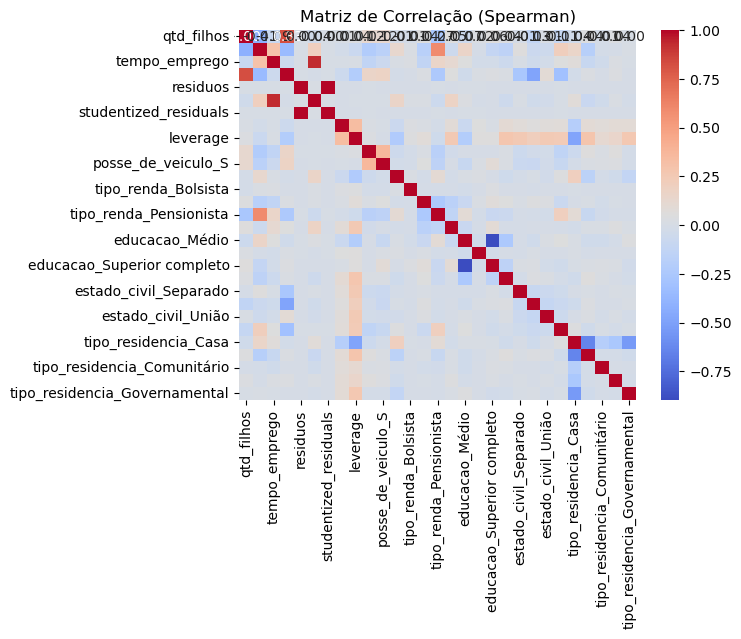

In [235]:
# Selecionar apenas as variáveis independentes
variaveis_independentes = train.drop(columns=['renda', 'log_renda'])

# Converter variáveis categóricas em dummies
variaveis_independentes = pd.get_dummies(variaveis_independentes, drop_first=True)

# Matriz de correlação de Spearman
correlacao_spearman = variaveis_independentes.corr(method='spearman')

# Exibir a matriz de correlação
sns.heatmap(correlacao_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação (Spearman)")
plt.show()

In [236]:
# Filtrar apenas as variáveis desejadas
variaveis_vif = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 
                 ]

# Criar um DataFrame com as variáveis selecionadas
X = df[variaveis_vif].copy()

In [237]:
# Adicionar constante ao DataFrame (necessário para calcular o VIF)
X = sm.add_constant(X)

# Calcular o VIF
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exibir os resultados
print("VIF das Variáveis:")
print(vif)

VIF das Variáveis:
                Variável        VIF
0                  const  39.992182
1             qtd_filhos   4.944076
2                  idade   1.232818
3          tempo_emprego   1.068189
4  qt_pessoas_residencia   4.827534


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [240]:
# Remover a variável 'const' do DataFrame
vif = vif[vif["Variável"] != "const"]

# Exibir resultados
print("VIF das Variáveis (sem const):")
print(vif)

VIF das Variáveis (sem const):
                Variável       VIF
1             qtd_filhos  4.944076
2                  idade  1.232818
3          tempo_emprego  1.068189
4  qt_pessoas_residencia  4.827534


In [242]:
df.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'log_renda'],
      dtype='object')

In [243]:
# Lista com todas as variáveis, excluindo 'renda' e 'log_renda'
variaveis = list(df.drop(columns=['renda', 'log_renda']).columns)

# Remover a variável 'estado_civil' da lista
if 'estado_civil' in variaveis:
    variaveis.remove('estado_civil')

# Criar a fórmula
formula = 'log_renda ~ ' + ' + '.join(variaveis)

In [244]:
# Ajustar o modelo na base de treino
model_adj = smf.ols(formula=formula, data=train).fit()
print(model_adj.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.703e+04
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:30:50   Log-Likelihood:            -7.4522e+05
No. Observations:              525000   AIC:                         1.490e+06
Df Residuals:                  524979   BIC:                         1.491e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [248]:
# Criar log da variável renda
df['log_renda'] = np.log(df['renda'])

# Remover variáveis não numéricas e com valores nulos
variaveis = list(df.select_dtypes(include=[np.number]).drop(columns=['renda', 'log_renda']).columns)


# Dividir os dados em treino e teste
X = df[variaveis]
y = df['log_renda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Adicionar constante
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Modelo Original
formula_original = 'log_renda ~ ' + ' + '.join(variaveis)
modelo_original = smf.ols(formula=formula_original, data=pd.concat([X_train, y_train], axis=1))
resultado_original = modelo_original.fit()

# Métricas do Modelo Original
y_pred_original = resultado_original.predict(X_test_const)
r2_original = r2_score(y_test, y_pred_original)
rmse_original = mean_squared_error(y_test, y_pred_original, squared=False)
mae_original = mean_absolute_error(y_test, y_pred_original)

# Avaliação de Multicolinearidade (VIF)
vif = pd.DataFrame()
vif["Variável"] = X_train_const.columns
vif["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
print("VIF das Variáveis:")
print(vif)

# Remover variáveis com VIF > 10
variaveis_ajustadas = list(vif[vif["VIF"] < 5]["Variável"])
if 'const' in variaveis_ajustadas:
    variaveis_ajustadas.remove('const')

# Modelo Ajustado
formula_ajustada = 'log_renda ~ ' + ' + '.join(variaveis_ajustadas)
modelo_ajustado = smf.ols(formula=formula_ajustada, data=pd.concat([X_train, y_train], axis=1))
resultado_ajustado = modelo_ajustado.fit()

# Métricas do Modelo Ajustado
X_test_const_ajustado = sm.add_constant(X_test[variaveis_ajustadas])
y_pred_ajustado = resultado_ajustado.predict(X_test_const_ajustado)
r2_ajustado = r2_score(y_test, y_pred_ajustado)
rmse_ajustado = mean_squared_error(y_test, y_pred_ajustado, squared=False)
mae_ajustado = mean_absolute_error(y_test, y_pred_ajustado)

# Comparar os Resultados
print("\n### Desempenho do Modelo Original ###")
print(f"R²: {r2_original:.4f}")
print(f"RMSE: {rmse_original:.4f}")
print(f"MAE: {mae_original:.4f}")

print("\n### Desempenho do Modelo Ajustado ###")
print(f"R²: {r2_ajustado:.4f}")
print(f"RMSE: {rmse_ajustado:.4f}")
print(f"MAE: {mae_ajustado:.4f}")

# Resumo dos Modelos
print("\n### Resumo do Modelo Original ###")
print(resultado_original.summary())

print("\n### Resumo do Modelo Ajustado ###")
print(resultado_ajustado.summary())

VIF das Variáveis:
                Variável        VIF
0                  const  40.108602
1             qtd_filhos   4.943323
2                  idade   1.232900
3          tempo_emprego   1.068303
4  qt_pessoas_residencia   4.828274

### Desempenho do Modelo Original ###
R²: 0.3766
RMSE: 1.0130
MAE: 0.8224

### Desempenho do Modelo Ajustado ###
R²: 0.3766
RMSE: 1.0130
MAE: 0.8224

### Resumo do Modelo Original ###
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 7.979e+04
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:30:51   Log-Likelihood:            -7.5180e+05
No. Observations:              525000   AIC:                         1.504e+06
Df Residuals:              

<span style="color:red">O modelo original contém somente as variáveis numéricas pelo fato de estar usando o VIF para avaliar a Multicolinearidade e portanto o modelo adjustado está igual ao original. </span>